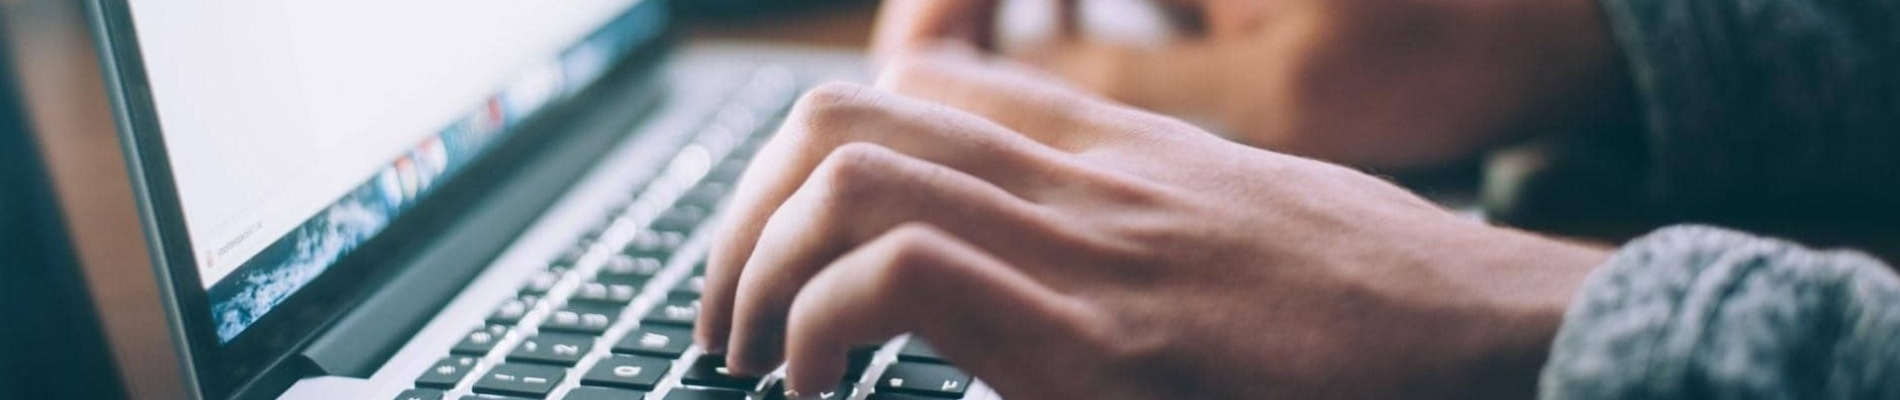

# Feedback Prize Competision EDA (JP/EN)

This notebook contains a EDA to submission for the Feedback Prize - Evaluating Student Writing competition in English/Japanese.

このノートブックは、
フィードバック賞-学生のライティングコンテストのコンペティションEDA（日本語バージョン）です。




In creating this notebook, I referred to the following great notebooks.

このノートブックを作成する際に、下記の素晴らしいノートブックを参考にしました。

[📖Feedback- Baseline🤗 Sentence Classifier [0.226]](https://www.kaggle.com/julian3833/feedback-baseline-sentence-classifier-0-226)

[🔥📊 Feedback Prize - EDA 📊🔥](https://www.kaggle.com/odins0n/feedback-prize-eda)

[🎓 Evaluating Student Writing - EDA](https://www.kaggle.com/yamqwe/evaluating-student-writing-eda))

[[Feedback prize] Simple EDA](https://www.kaggle.com/ilialar/feedback-prize-simple-eda)


In [ ]:
import os
import spacy
import wordcloud
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from pathlib import Path
import spacy
from spacy import displacy
from pylab import cm, matplotlib

import re
import nltk
import spacy
import random
import string
from PIL import Image
from tqdm import tqdm
from collections import Counter
from spacy.util import minibatch
from nltk.corpus import stopwords
from spacy.util import compounding
import plotly.figure_factory as ff
from plotly import graph_objs as go
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import warnings; warnings.filterwarnings("ignore")

## Load data 

In [ ]:
train_dir = "../input/feedback-prize-2021/train/"
test_dir = "../input/feedback-prize-2021/test/"
train_files = os.listdir(train_dir)
test_files = os.listdir(test_dir)

for file in range(len(train_files)):
    train_files[file] = str(train_dir) + "/" +  str(train_files[file])
for file in range(len(test_files)):
    test_files[file] = str(test_dir) + "/" +  str(test_files[file])
    


train = pd.read_csv('../input/feedback-prize-2021/train.csv')
sub = pd.read_csv('../input/feedback-prize-2021/sample_submission.csv')

In [ ]:
print(len(train))

In [ ]:

train=train[:10000]
train_names, train_texts = [], []
for f in tqdm(list(os.listdir('../input/feedback-prize-2021/train'))):
    train_names.append(f.replace('.txt', ''))
    train_texts.append(open('../input/feedback-prize-2021/train/' + f, 'r').read())
train_texts = pd.DataFrame({'id': train_names, 'text': train_texts})
train_texts
train = pd.merge(train, train_texts, how = 'left', on = 'id')
train
test_names, test_texts = [], []
for f in tqdm(list(os.listdir('../input/feedback-prize-2021/test'))):
    test_names.append(f.replace('.txt', ''))
    test_texts.append(open('../input/feedback-prize-2021/test/' + f, 'r').read())
test_texts = pd.DataFrame({'id': test_names, 'text': test_texts})
test_texts
test = pd.merge(sub, test_texts, how = 'left', on = 'id')
test

In [ ]:
train.describe()

# # Train data

train.csv contains 10 rows with annotation for this file. Each row corresponds to one discourse element and contains the following information (source: https://www.kaggle.com/c/feedback-prize-2021/data):

* id - ID code for essay response
* discourse_id - ID code for discourse element
* discourse_start - character position where discourse element begins in the essay response
* discourse_end - character position where discourse element ends in the essay response
* discourse_text - text of discourse element
* discourse_type - classification of discourse element
* discourse_type_num - enumerated class label of discourse element
* predictionstring - the word indices of the training sample, as required for predictions
As you can see we have both symbol and words level annotation (we can use any of them in model but need the word level one for submission).

train.csvには、10個の要素が含まれています。 参考：https：//www.kaggle.com/c/feedback-prize-2021/data）。

* id-エッセイのIDコード（trainファイルのエッセイ名と同じ）
* discourse_id-要素のIDコード
* discourse_start-文章の中で談話要素が始まる文字位置
* discourse_end-文章の中で談話要素が終了する文字位置
* discourse_text-談話要素のテキスト
* discourse_type-談話要素の分類（Target）
* discourse_type_num-談話要素の列挙されたクラスラベル
* predictionstring-予測に必要なトレーニングサンプルの単語インデックス



In [ ]:
def print_text(text_id):
    with open(f'/kaggle/input/feedback-prize-2021/train/{text_id}.txt') as f:
        lines = f.readlines()
    print(''.join(lines))
    
print_text('423A1CA112E2')

## How many words are included for each text?

Tokenizes the text and prints the number of words per text.

テキストをトークン化して、テキストごとの単語数を出力します。

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('roberta-base')

In [ ]:

texts = []

ids = train['id'].unique().tolist()
len(ids)

for example in ids:
    with open(train_dir+f'{example}.txt', 'r') as file: data = file.read()
    texts.append({
        'text': data,
        'n_tokens': len(tokenizer(data)['input_ids'])
    })
     
df = pd.DataFrame(texts)

In [ ]:
print(df.describe())

The number of words in an essay varies from about 150 to 10000.
It seems to be composed of about 500 words on average.

1つのエッセイの単語数は、150〜10000とばらつきがあります。
平均500単語程で構成されているようです。

# Submission data (Target)

This competition is a student's writing　to classify into 7 categories and submit the results.

* Lead
* Position
* Evidence
* Claim
* Concluding Statement
* Counterclaim
* Rebuttal



このコンペティションは、学生の文章を7つに分類して結果を提出するという内容です。

* Lead(導入)
* Position（ポジション）
* Evidence（証拠）
* Claim（訴え）
* Concluding Statement（結論）
* Counterclaim（反訴）
* Rebuttal（反論）





In [ ]:
d_type=pd.DataFrame(train["discourse_type"].value_counts())
fig = px.bar(x =d_type.index,
y = d_type["discourse_type"] , color = np.unique(train["discourse_type"]),color_continuous_scale="Emrld")
fig.update_xaxes(title="Classes")
fig.update_yaxes(title = "Number of Rows")
fig.update_layout(showlegend = True,title = {
        'text': 'Discourse Type Distribution ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

In [ ]:
sub = pd.read_csv('../input/feedback-prize-2021/sample_submission.csv')
sub.head()

We can see that we have to submit the class and predictionstring from the sample.

Predictionstring  is the index of the word corresponding to class (discourse_type).

If you apply discourse_type to a sentence as shown below, you will notice that there are some words that do not fall into the seven classes. 

classとpredictionstringを提出しなくてはならないことがわかります。

predictionstringとは、class（discourse_type）に相当する単語のインデックスのことです。

下記のように、文章にdiscourse_typeを当てはめてみると、7つのクラスに分類されない単語がいくつかあることに気づくと思います。

In [ ]:
path = Path('../input/feedback-prize-2021/train')

colors = {
            'Lead': '#8000ff',
            'Position': '#2b7ff6',
            'Evidence': '#2adddd',
            'Claim': '#80ffb4',
            'Concluding Statement': 'd4dd80',
            'Counterclaim': '#ff8042',
            'Rebuttal': '#ff0000'
         }

def visualize(example):
    ents = []
    for i, row in train[train['id'] == example].iterrows():
        ents.append({
                        'start': int(row['discourse_start']), 
                         'end': int(row['discourse_end']), 
                         'label': row['discourse_type']
                    })

    with open(path/f'{example}.txt', 'r') as file: data = file.read()

    doc2 = {
        "text": data,
        "ents": ents,
        "title": example
    }

    options = {"ents": train.discourse_type.unique().tolist(), "colors": colors}
    displacy.render(doc2, style="ent", options=options, manual=True, jupyter=True)

examples = train['id'].sample(n=5, random_state=42).values.tolist()

for ex in examples:
    visualize(ex)
    print('\n')

# About Writing Pattern

I think that sentence structure is sometimes the same ,　especially the first and last sentences.I try to check up.

特に最初と最後の文で 文型が同じである場合もあると思います。調べて見ましょう

## What types are often selected in the first section?

Let's see which type is most selected in the first discourse_type of each text. 


各テキストの最初のクラス（discourse_type）で最も選択されているタイプを見てみましょう。

In [ ]:
first_type=[train[train['id']==id]['discourse_type'].iloc[0] for id in train['id'].unique()]
d_type=pd.DataFrame(first_type).value_counts()
fig = px.bar(x =d_type.index.get_level_values(0),
y = d_type, color = d_type.index.get_level_values(0),color_continuous_scale="Emrld")
fig.update_xaxes(title="Classes")
fig.update_yaxes(title = "Number of Rows")
fig.update_layout(showlegend = True,title = {
        'text': 'Which types are often selected in the first section?',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

You can see that Lead is the most common type at the beginning of the essay.

エッセイの1番初めに分類されるのは、Lead（導入）が最も多いということが分かります。

## Which types are often selected in the last section?


In [ ]:
last_type=[train[train['id']==id]['discourse_type'].iloc[-1] for id in train['id'].unique()]
d_type=pd.DataFrame(last_type).value_counts()
fig = px.bar(x =d_type.index.get_level_values(0),
y = d_type, color = d_type.index.get_level_values(0),color_continuous_scale="Emrld")
fig.update_xaxes(title="Classes")
fig.update_yaxes(title = "Number of Rows")
fig.update_layout(showlegend = True,title = {
        'text': 'What types are often selected in the last section?',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

You can see that the types classified at the end of the essay are overwhelmingly Concluding Statements.

エッセイの最後に分類されるタイプは、Concluding　Statement（結論）が圧倒的に多いことが分かります。

Let's take a look at the patterns and the number of types with many sentence structures.

それでは文章構成の多いパターンを見てみましょう

In [ ]:
num=[]
pattern=[]
for i in range(len(train['id'].unique())):
        id=train['id'].unique()[i]
        data_a=train[train['id']==id]
        num.append(len(data_a))
        a=''
        for n in range(len(data_a)):
            a=a+data_a['discourse_type'].iloc[n]+'_'
        pattern.append(a)
patterns=pd.DataFrame(pattern,columns={'discourse_types_pattern'})

In [ ]:
patterns_=pd.DataFrame(patterns.value_counts(),columns={'count'})
patterns_[:10]

In [ ]:
plt.barh(patterns_.index.get_level_values(0)[:10],patterns_['count'][:10].values)

Since the 59 sentences have the same pattern, there seems to be some tendency.

59個の文章で同じパターンがあるので、傾向はありそうです。

## How many words are included in each type of text

更に、discourse_typeごとに単語数を見て見ます。(抜粋:[🎓 Evaluating Student Writing - EDA](https://www.kaggle.com/yamqwe/evaluating-student-writing-eda))

In [ ]:
train['selected_text'] = train['discourse_text']

In [ ]:
train['Num_words_ST'] = train['discourse_text'].apply(lambda x:len(str(x).split())) #Number Of words in Selected Text
train['Num_word_text'] = train['text'].apply(lambda x:len(str(x).split())) #Number Of words in main text
train['difference_in_words'] = train['Num_word_text'] - train['Num_words_ST'] #Difference in Number of words text and Selected Text

In [ ]:
for i in train['discourse_type'].unique():    
    plt.figure(figsize=(12,6))
    sns.distplot(train[train['discourse_type']==i]['difference_in_words'],kde=False)
    plt.show()

I'm continueing to writing this notebook.

# LongFormer/The Long-Document Transformer

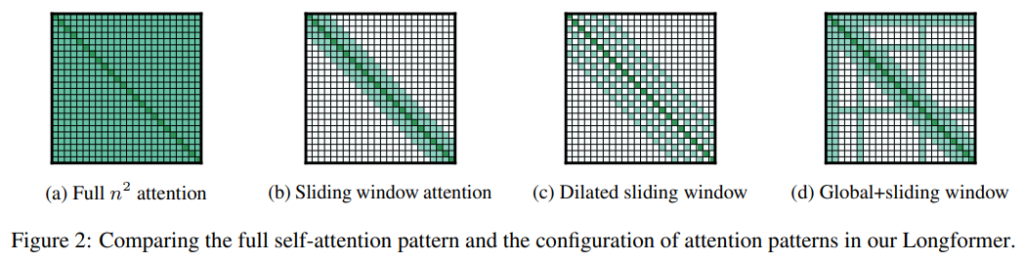

Longformer is a model that responds to the sudden increase in memory consumption  for long sentences by Transformer by devising a self-attention method.

This means you can reduce memory consumption, speed up calculations, and use Transformer-based models for long sentences.



It also has the same pre-learning-fine tuning as BERT and RoBERTa, achieving accuracy that surpasses BERT and RoBERTa for long sentence tasks.


Longformer devises the method of Scaled Dot-Production attention.

Simply put, Scaled Dot-Product attention focuses attention from every word to every word, which leads to memory consumption in 𝑛2, but from important word to important word. Only pay attention to it.



Longformerは、Transformerによる長い文のメモリ消費量の急激な増加に、self-attentionの方法を考案することで対応するモデルです。

つまり、メモリ消費量を削減し、計算を高速化して、長い文章に対してもTransformerベースのモデルを使えるようになります。


また、BERTやRoBERTaと同じ事前学習の微調整が可能で、長い文のタスクでBERTやRoBERTaを超える精度を実現します。


Longformerでは、そのScaled Dot-Production attentionの方法を工夫します。

簡単に言うと、Scaled Dot-Product attentionでは、すべての単語からすべての単語へ注意を向けており、それが𝑛2のメモリ消費量に繋がっていましたが、それを重要な単語から重要な単語へのみ注意を向けるようにします。


In [ ]:
# DECLARE HOW MANY GPUS YOU WISH TO USE. 
# KAGGLE ONLY HAS 1, BUT OFFLINE, YOU CAN USE MORE
os.environ["CUDA_VISIBLE_DEVICES"]="0" #0,1,2,3 for four gpu

# VERSION FOR SAVING/LOADING MODEL WEIGHTS
# THIS SHOULD MATCH THE MODEL IN LOAD_MODEL_FROM
VER=14 

# IF VARIABLE IS NONE, THEN NOTEBOOK COMPUTES TOKENS
# OTHERWISE NOTEBOOK LOADS TOKENS FROM PATH
LOAD_TOKENS_FROM = '../input/tf-longformer-v12'

# IF VARIABLE IS NONE, THEN NOTEBOOK TRAINS A NEW MODEL
# OTHERWISE IT LOADS YOUR PREVIOUSLY TRAINED MODEL
LOAD_MODEL_FROM = '../input/tflongformerv141'

# IF FOLLOWING IS NONE, THEN NOTEBOOK 
# USES INTERNET AND DOWNLOADS HUGGINGFACE 
# CONFIG, TOKENIZER, AND MODEL
DOWNLOADED_MODEL_PATH = '../input/tf-longformer-v12'


if DOWNLOADED_MODEL_PATH is None:
    DOWNLOADED_MODEL_PATH = 'model'    
MODEL_NAME = 'allenai/longformer-base-4096'

In [ ]:
if DOWNLOADED_MODEL_PATH == 'model':
    os.mkdir('model')
    
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    tokenizer.save_pretrained('model')

    config = AutoConfig.from_pretrained(MODEL_NAME) 
    config.save_pretrained('model')

    backbone = TFAutoModel.from_pretrained(MODEL_NAME, config=config)
    backbone.save_pretrained('model')

In [ ]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from transformers import *
print('TF version',tf.__version__)

In [ ]:
#USE MULTIPLE GPUS
if os.environ["CUDA_VISIBLE_DEVICES"].count(',') == 0:
    strategy = tf.distribute.get_strategy()
    print('single strategy')
else:
    strategy = tf.distribute.MirroredStrategy()
    print('multiple strategy')

In [ ]:
tf.config.optimizer.set_experimental_options({"auto_mixed_precision": True})
print('Mixed precision enabled')

In [ ]:
IDS = train.id.unique()
MAX_LEN = 1024

# THE TOKENS AND ATTENTION ARRAYS
tokenizer = AutoTokenizer.from_pretrained(DOWNLOADED_MODEL_PATH)
train_tokens = np.zeros((len(IDS),MAX_LEN), dtype='int32')
train_attention = np.zeros((len(IDS),MAX_LEN), dtype='int32')

# THE 14 CLASSES FOR NER
lead_b = np.zeros((len(IDS),MAX_LEN))
lead_i = np.zeros((len(IDS),MAX_LEN))

position_b = np.zeros((len(IDS),MAX_LEN))
position_i = np.zeros((len(IDS),MAX_LEN))

evidence_b = np.zeros((len(IDS),MAX_LEN))
evidence_i = np.zeros((len(IDS),MAX_LEN))

claim_b = np.zeros((len(IDS),MAX_LEN))
claim_i = np.zeros((len(IDS),MAX_LEN))

conclusion_b = np.zeros((len(IDS),MAX_LEN))
conclusion_i = np.zeros((len(IDS),MAX_LEN))

counterclaim_b = np.zeros((len(IDS),MAX_LEN))
counterclaim_i = np.zeros((len(IDS),MAX_LEN))

rebuttal_b = np.zeros((len(IDS),MAX_LEN))
rebuttal_i = np.zeros((len(IDS),MAX_LEN))

# HELPER VARIABLES
train_lens = []
targets_b = [lead_b, position_b, evidence_b, claim_b, conclusion_b, counterclaim_b, rebuttal_b]
targets_i = [lead_i, position_i, evidence_i, claim_i, conclusion_i, counterclaim_i, rebuttal_i]
target_map = {'Lead':0, 'Position':1, 'Evidence':2, 'Claim':3, 'Concluding Statement':4,
             'Counterclaim':5, 'Rebuttal':6}

In [ ]:
# WE ASSUME DATAFRAME IS ASCENDING WHICH IT IS
assert( np.sum(train.groupby('id')['discourse_start'].diff()<=0)==0 )

# FOR LOOP THROUGH EACH TRAIN TEXT
for id_num in range(len(IDS)):
    if LOAD_TOKENS_FROM: break
    if id_num%100==0: print(id_num,', ',end='')
        
    # READ TRAIN TEXT, TOKENIZE, AND SAVE IN TOKEN ARRAYS    
    n = IDS[id_num]
    name = f'../input/feedback-prize-2021/train/{n}.txt'
    txt = open(name, 'r').read()
    train_lens.append( len(txt.split()))
    tokens = tokenizer.encode_plus(txt, max_length=MAX_LEN, padding='max_length',
                                   truncation=True, return_offsets_mapping=True)
    train_tokens[id_num,] = tokens['input_ids']
    train_attention[id_num,] = tokens['attention_mask']
    
    # FIND TARGETS IN TEXT AND SAVE IN TARGET ARRAYS
    offsets = tokens['offset_mapping']
    offset_index = 0
    df = train.loc[train.id==n]
    for index,row in df.iterrows():
        a = row.discourse_start
        b = row.discourse_end
        if offset_index>len(offsets)-1:
            break
        c = offsets[offset_index][0]
        d = offsets[offset_index][1]
        beginning = True
        while b>c:
            if (c>=a)&(b>=d):
                k = target_map[row.discourse_type]
                if beginning:
                    targets_b[k][id_num][offset_index] = 1
                    beginning = False
                else:
                    targets_i[k][id_num][offset_index] = 1
            offset_index += 1
            if offset_index>len(offsets)-1:
                break
            c = offsets[offset_index][0]
            d = offsets[offset_index][1]

In [ ]:
if LOAD_TOKENS_FROM is None:
    targets = np.zeros((len(IDS),MAX_LEN,15), dtype='int32')
    for k in range(7):
        targets[:,:,2*k] = targets_b[k]
        targets[:,:,2*k+1] = targets_i[k]
    targets[:,:,14] = 1-np.max(targets,axis=-1)

In [ ]:
if LOAD_TOKENS_FROM is None:
    np.save(f'targets_{MAX_LEN}', targets)
    np.save(f'tokens_{MAX_LEN}', train_tokens)
    np.save(f'attention_{MAX_LEN}', train_attention)
    print('Saved NER tokens')
else:
    targets = np.load(f'{LOAD_TOKENS_FROM}/targets_{MAX_LEN}.npy')
    train_tokens = np.load(f'{LOAD_TOKENS_FROM}/tokens_{MAX_LEN}.npy')
    train_attention = np.load(f'{LOAD_TOKENS_FROM}/attention_{MAX_LEN}.npy')
    print('Loaded NER tokens')

In [ ]:
def build_model():
    
    tokens = tf.keras.layers.Input(shape=(MAX_LEN,), name = 'tokens', dtype=tf.int32)
    attention = tf.keras.layers.Input(shape=(MAX_LEN,), name = 'attention', dtype=tf.int32)
    
    config = AutoConfig.from_pretrained(DOWNLOADED_MODEL_PATH+'/config.json') 
    backbone = TFAutoModel.from_pretrained(DOWNLOADED_MODEL_PATH+'/tf_model.h5', config=config)
    
    x = backbone(tokens, attention_mask=attention)
    x = tf.keras.layers.Dense(256, activation='relu')(x[0])
    x = tf.keras.layers.Dense(15, activation='softmax', dtype='float32')(x)
    
    model = tf.keras.Model(inputs=[tokens,attention], outputs=x)
    model.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-4),
                  loss = [tf.keras.losses.CategoricalCrossentropy()],
                  metrics = [tf.keras.metrics.CategoricalAccuracy()])
    
    return model

In [ ]:
with strategy.scope():
    model = build_model()

In [ ]:
# LEARNING RATE SCHEDULE AND MODEL CHECKPOINT
EPOCHS = 5
BATCH_SIZE = 4 
LRS = [0.25e-4, 0.25e-4, 0.25e-4, 0.25e-4, 0.25e-5] 
def lrfn(epoch):
    return LRS[epoch]
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

In [ ]:
# TRAIN VALID SPLIT 90% 10%
np.random.seed(42)
train_idx = np.random.choice(np.arange(len(IDS)),int(0.9*len(IDS)),replace=False)
valid_idx = np.setdiff1d(np.arange(len(IDS)),train_idx)
np.random.seed(None)
print('Train size',len(train_idx),', Valid size',len(valid_idx))

In [ ]:
# LOAD MODEL
if LOAD_MODEL_FROM:
    model.load_weights(f'{LOAD_MODEL_FROM}/long_v{VER}.h5')
    
# OR TRAIN MODEL
else:
    model.fit(x = [train_tokens[train_idx,], train_attention[train_idx,]],
          y = targets[train_idx,],
          validation_data = ([train_tokens[valid_idx,], train_attention[valid_idx,]],
                             targets[valid_idx,]),
          callbacks = [lr_callback],
          epochs = EPOCHS,
          batch_size = BATCH_SIZE,
          verbose = 2)

    # SAVE MODEL WEIGHTS
    model.save_weights(f'long_v{VER}.h5')

In [ ]:
p = model.predict([train_tokens[valid_idx,], train_attention[valid_idx,]], 
                  batch_size=16, verbose=2)
print('OOF predictions shape:',p.shape)
oof_preds = np.argmax(p,axis=-1)

In [ ]:
target_map_rev = {0:'Lead', 1:'Position', 2:'Evidence', 3:'Claim', 4:'Concluding Statement',
             5:'Counterclaim', 6:'Rebuttal', 7:'blank'}

In [ ]:
def get_preds(dataset='train', verbose=True, text_ids=IDS[valid_idx], preds=oof_preds):
    all_predictions = []

    for id_num in range(len(preds)):
    
        # GET ID
        if (id_num%100==0)&(verbose): 
            print(id_num,', ',end='')
        n = text_ids[id_num]
    
        # GET TOKEN POSITIONS IN CHARS
        name = f'../input/feedback-prize-2021/{dataset}/{n}.txt'
        txt = open(name, 'r').read()
        tokens = tokenizer.encode_plus(txt, max_length=MAX_LEN, padding='max_length',
                                   truncation=True, return_offsets_mapping=True)
        off = tokens['offset_mapping']
    
        # GET WORD POSITIONS IN CHARS
        w = []
        blank = True
        for i in range(len(txt)):
            if (txt[i]!=' ')&(txt[i]!='\n')&(txt[i]!='\xa0')&(txt[i]!='\x85')&(blank==True):
                w.append(i)
                blank=False
            elif (txt[i]==' ')|(txt[i]=='\n')|(txt[i]=='\xa0')|(txt[i]=='\x85'):
                blank=True
        w.append(1e6)
            
        # MAPPING FROM TOKENS TO WORDS
        word_map = -1 * np.ones(MAX_LEN,dtype='int32')
        w_i = 0
        for i in range(len(off)):
            if off[i][1]==0: continue
            while off[i][0]>=w[w_i+1]: w_i += 1
            word_map[i] = int(w_i)
        
        # CONVERT TOKEN PREDICTIONS INTO WORD LABELS
        ### KEY: ###
        # 0: LEAD_B, 1: LEAD_I
        # 2: POSITION_B, 3: POSITION_I
        # 4: EVIDENCE_B, 5: EVIDENCE_I
        # 6: CLAIM_B, 7: CLAIM_I
        # 8: CONCLUSION_B, 9: CONCLUSION_I
        # 10: COUNTERCLAIM_B, 11: COUNTERCLAIM_I
        # 12: REBUTTAL_B, 13: REBUTTAL_I
        # 14: NOTHING i.e. O
        ### NOTE THESE VALUES ARE DIVIDED BY 2 IN NEXT CODE LINE
        pred = preds[id_num,]/2.0
    
        i = 0
        while i<MAX_LEN:
            prediction = []
            start = pred[i]
            if start in [0,1,2,3,4,5,6,7]:
                prediction.append(word_map[i])
                i += 1
                if i>=MAX_LEN: break
                while pred[i]==start+0.5:
                    if not word_map[i] in prediction:
                        prediction.append(word_map[i])
                    i += 1
                    if i>=MAX_LEN: break
            else:
                i += 1
            prediction = [x for x in prediction if x!=-1]
            if len(prediction)>4:
                all_predictions.append( (n, target_map_rev[int(start)], 
                                ' '.join([str(x) for x in prediction]) ) )
                
    # MAKE DATAFRAME
    df = pd.DataFrame(all_predictions)
    df.columns = ['id','class','predictionstring']
    
    return df

In [ ]:
oof = get_preds( dataset='train', verbose=True, text_ids=IDS[valid_idx] )
oof.head()

In [ ]:
print('The following classes are present in oof preds:')
oof['class'].unique()

In [ ]:
# CODE FROM : Rob Mulla @robikscube
# https://www.kaggle.com/robikscube/student-writing-competition-twitch
def calc_overlap(row):
    """
    Calculates the overlap between prediction and
    ground truth and overlap percentages used for determining
    true positives.
    """
    set_pred = set(row.predictionstring_pred.split(' '))
    set_gt = set(row.predictionstring_gt.split(' '))
    # Length of each and intersection
    len_gt = len(set_gt)
    len_pred = len(set_pred)
    inter = len(set_gt.intersection(set_pred))
    overlap_1 = inter / len_gt
    overlap_2 = inter/ len_pred
    return [overlap_1, overlap_2]


def score_feedback_comp(pred_df, gt_df):
    """
    A function that scores for the kaggle
        Student Writing Competition
        
    Uses the steps in the evaluation page here:
        https://www.kaggle.com/c/feedback-prize-2021/overview/evaluation
    """
    gt_df = gt_df[['id','discourse_type','predictionstring']] \
        .reset_index(drop=True).copy()
    pred_df = pred_df[['id','class','predictionstring']] \
        .reset_index(drop=True).copy()
    pred_df['pred_id'] = pred_df.index
    gt_df['gt_id'] = gt_df.index
    # Step 1. all ground truths and predictions for a given class are compared.
    joined = pred_df.merge(gt_df,
                           left_on=['id','class'],
                           right_on=['id','discourse_type'],
                           how='outer',
                           suffixes=('_pred','_gt')
                          )
    joined['predictionstring_gt'] = joined['predictionstring_gt'].fillna(' ')
    joined['predictionstring_pred'] = joined['predictionstring_pred'].fillna(' ')

    joined['overlaps'] = joined.apply(calc_overlap, axis=1)

    # 2. If the overlap between the ground truth and prediction is >= 0.5, 
    # and the overlap between the prediction and the ground truth >= 0.5,
    # the prediction is a match and considered a true positive.
    # If multiple matches exist, the match with the highest pair of overlaps is taken.
    joined['overlap1'] = joined['overlaps'].apply(lambda x: eval(str(x))[0])
    joined['overlap2'] = joined['overlaps'].apply(lambda x: eval(str(x))[1])


    joined['potential_TP'] = (joined['overlap1'] >= 0.5) & (joined['overlap2'] >= 0.5)
    joined['max_overlap'] = joined[['overlap1','overlap2']].max(axis=1)
    tp_pred_ids = joined.query('potential_TP') \
        .sort_values('max_overlap', ascending=False) \
        .groupby(['id','predictionstring_gt']).first()['pred_id'].values

    # 3. Any unmatched ground truths are false negatives
    # and any unmatched predictions are false positives.
    fp_pred_ids = [p for p in joined['pred_id'].unique() if p not in tp_pred_ids]

    matched_gt_ids = joined.query('potential_TP')['gt_id'].unique()
    unmatched_gt_ids = [c for c in joined['gt_id'].unique() if c not in matched_gt_ids]

    # Get numbers of each type
    TP = len(tp_pred_ids)
    FP = len(fp_pred_ids)
    FN = len(unmatched_gt_ids)
    #calc microf1
    my_f1_score = TP / (TP + 0.5*(FP+FN))
    return my_f1_score

In [ ]:
# VALID DATAFRAME
valid = train.loc[train['id'].isin(IDS[valid_idx])]

In [ ]:
f1s = []
CLASSES = oof['class'].unique()
for c in CLASSES:
    pred_df = oof.loc[oof['class']==c].copy()
    gt_df = valid.loc[valid['discourse_type']==c].copy()
    f1 = score_feedback_comp(pred_df, gt_df)
    print(c,f1)
    f1s.append(f1)
print()
print('Overall',np.mean(f1s))

In [ ]:
# GET TEST TEXT IDS
files = os.listdir('../input/feedback-prize-2021/test')
TEST_IDS = [f.replace('.txt','') for f in files if 'txt' in f]
print('There are',len(TEST_IDS),'test texts.')

In [ ]:
# CONVERT TEST TEXT TO TOKENS
test_tokens = np.zeros((len(TEST_IDS),MAX_LEN), dtype='int32')
test_attention = np.zeros((len(TEST_IDS),MAX_LEN), dtype='int32')

for id_num in range(len(TEST_IDS)):
        
    # READ TRAIN TEXT, TOKENIZE, AND SAVE IN TOKEN ARRAYS    
    n = TEST_IDS[id_num]
    name = f'../input/feedback-prize-2021/test/{n}.txt'
    txt = open(name, 'r').read()
    tokens = tokenizer.encode_plus(txt, max_length=MAX_LEN, padding='max_length',
                                   truncation=True, return_offsets_mapping=True)
    test_tokens[id_num,] = tokens['input_ids']
    test_attention[id_num,] = tokens['attention_mask']

In [ ]:
# INFER TEST TEXTS
p = model.predict([test_tokens, test_attention], 
                  batch_size=16, verbose=2)
print('Test predictions shape:',p.shape)
test_preds = np.argmax(p,axis=-1)

In [ ]:
# GET TEST PREDICIONS
sub = get_preds( dataset='test', verbose=False, text_ids=TEST_IDS, preds=test_preds )
sub.head()

In [ ]:
# WRITE SUBMISSION CSV
sub.to_csv('submission.csv',index=False)